In [1]:
from thermoengine import model

import matplotlib.pyplot as plt
import numpy as np

In [2]:
chem = model.core.chem

modelDB = model.Database()
liq_phs = modelDB.get_phase('Liq')

OXIDES = np.array(liq_phs.OXIDES)

/Users/aswolf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Work out melts liquid endmember stoichiometry

In [3]:

mol_liq_oxides = np.array(
    [liq_phs.calc_endmember_comp(imol, method='intrinsic') 
     for imol in np.eye(OXIDES.size)])[:-1]



/Users/aswolf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


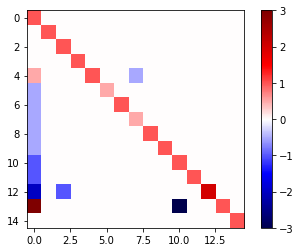

In [4]:
max_coef = np.max(np.abs(mol_liq_oxides))

plt.imshow(mol_liq_oxides, vmin=-max_coef, vmax=+max_coef, cmap='seismic')
plt.colorbar()

# Select Melt Composition
* Set based on oxide wt composition
* convert to molar oxides
* map to MELTS liquid endmembers

In [5]:
melt_comp_wts = {'MgO':36.9, 'CaO':3.3, 'Al2O3':4.6, 'SiO2':50.7, 
                 'Na2O':3e-7, 'K2O':3e-10, 'FeO':3.5}

oxide_wts = chem.format_mol_oxide_comp(melt_comp_wts)
print('Total wt% = ', oxide_wts.sum())


oxide_mols = chem.wt_to_mol_oxide(oxide_wts)

mol_liq = liq_phs.calc_endmember_comp(oxide_mols, method='intrinsic')


print('MELTS liquid components:')
[(iendmem, imol) for iendmem, imol in zip(liq_phs.endmember_names, mol_liq)]

Total wt% =  99.0000003003
MELTS liquid components:


[('SiO2', 0.15838697508130498),
 ('TiO2', 0.0),
 ('Al2O3', 0.02359560573965866),
 ('Fe2O3', 0.0),
 ('MgCr2O4', 0.0),
 ('Fe2SiO4', 0.012739184132009907),
 ('MnSi0.5O2', 0.0),
 ('Mg2SiO4', 0.23941562384917317),
 ('NiSi0.5O2', 0.0),
 ('CoSi0.5O2', 0.0),
 ('CaSiO3', 0.030776495082866905),
 ('Na2SiO3', 2.5315452142440734e-09),
 ('KAlSiO4', 3.331425715924994e-12),
 ('Ca3(PO4)2', 0.0),
 ('H2O', 0.0)]

# Set T/P conditions

In [6]:
T = 2000
P = 1e-10

In [7]:
mu0_endmem = np.array([liq_phs.gibbs_energy(T, P, mol=imol) 
                       for imol in np.eye(mol_liq.size)])
mu0_oxides = np.dot(mol_liq_oxides, mu0_endmem)

In [8]:
print([(iox,imu0) for (iox,imu0) in zip(OXIDES,mu0_oxides)])

[('SiO2', -1126992.7902225351), ('TiO2', -1194760.8804278611), ('Al2O3', -1993094.840206883), ('Fe2O3', -1289181.1090128773), ('Cr2O3', -1525071.7621083637), ('FeO', -520541.7999473879), ('MnO', -639329.1444909758), ('MgO', -775945.8385311001), ('NiO', -431756.69748280186), ('CoO', -485452.84777541074), ('CaO', -908523.1498144204), ('Na2O', -989925.3897713323), ('K2O', -1172300.7486442425), ('P2O5', -2489347.169337852), ('H2O', -537941.2528068476)]


In [9]:
mu_endmem = liq_phs.chem_potential(T, P, mol=mol_liq).squeeze()
mu_oxides = np.dot(mol_liq_oxides, mu_endmem)


In [10]:
R = 8.314

dmu_oxides = mu_oxides-mu0_oxides
activities = np.exp(dmu_oxides/(R*T))
activity_const = activities/oxide_mols[:-1]


dmu_endmem = mu_endmem-mu0_endmem
activities_endmem = np.exp(dmu_endmem/(R*T))
activity_const_endmem = activities_endmem/mol_liq


mask_oxides = oxide_mols[:-1] >0
mask_endmem = mol_liq >0

<ipython-input-10-50eee85db206>:5: RuntimeWarning: divide by zero encountered in true_divide
  activity_const = activities/oxide_mols[:-1]
<ipython-input-10-50eee85db206>:10: RuntimeWarning: divide by zero encountered in true_divide
  activity_const_endmem = activities_endmem/mol_liq


In [11]:
display([(iox, iconst) for iox, iconst in 
         zip(OXIDES[:-1][mask_oxides],activity_const[mask_oxides])])
display([(iend, iconst) for iend, iconst in 
         zip(liq_phs.endmember_names[mask_endmem],activity_const_endmem[mask_endmem])])


[('SiO2', 0.9228937901709457),
 ('Al2O3', 0.3077891683569934),
 ('FeO', 7.3282756561894535),
 ('MgO', 2.2772062371133077),
 ('CaO', 1.862601094352939),
 ('Na2O', 0.12157605106407725),
 ('K2O', 3.6682652594510654e-08)]

[('SiO2', 2.57148607402616),
 ('Al2O3', 0.30778916837872156),
 ('Fe2SiO4', 1.1145738305205815),
 ('Mg2SiO4', 2.02265051899522),
 ('CaSiO3', 0.7586186148161844),
 ('Na2SiO3', 0.049516697768875836),
 ('KAlSiO4', 2.57540879550871)]

(0.01, 100.0)

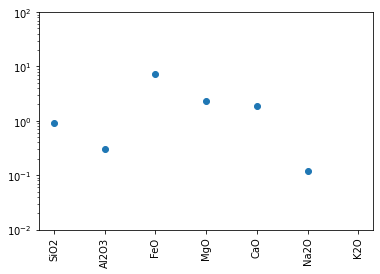

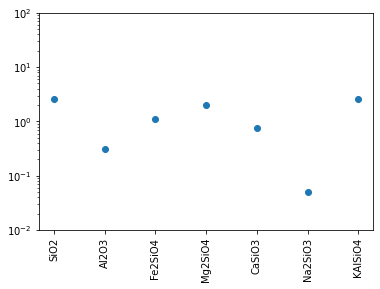

In [12]:

plt.figure()
plt.semilogy(activity_const[mask_oxides], 'o')
plt.xticks(ticks=np.arange(mask_oxides.sum()), 
           labels=OXIDES[:-1][mask_oxides], 
           rotation='vertical');
plt.ylim(1e-2, 1e2)

plt.figure()
plt.semilogy(activity_const_endmem[mask_endmem], 'o')
plt.xticks(ticks=np.arange(mask_endmem.sum()), 
           labels=liq_phs.endmember_names[mask_endmem], 
           rotation='vertical');

plt.ylim(1e-2, 1e2)


In [13]:
liq_phs.endmember_names

/Users/aswolf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MgCr2O4', 'Fe2SiO4',
       'MnSi0.5O2', 'Mg2SiO4', 'NiSi0.5O2', 'CoSi0.5O2', 'CaSiO3',
       'Na2SiO3', 'KAlSiO4', 'Ca3(PO4)2', 'H2O'], dtype='<U9')

In [14]:
liq_props = liq_phs.props
liq_props.keys()

odict_keys(['abbrev', 'phase_name', 'class_name', 'identifier', 'endmember_name', 'endmember_ids', 'formula', 'atom_num', 'molwt', 'elemental_entropy', 'element_comp', 'mol_oxide_comp', 'endmember_num', 'endmember_id', 'species_num', 'oxide_space', 'species_name', 'species_elms'])

In [15]:

liq_props['element_comp']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.]])

In [16]:
# chem.oxide_to_elem([liq_phs.OXIDES[0]], [1])

In [17]:
chem.oxide_props

OrderedDict([('oxide_num', 16),
             ('oxides',
              array(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'Cr2O3', 'FeO', 'MnO', 'MgO',
                     'NiO', 'CoO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O', 'CO2'],
                    dtype='<U5')),
             ('cations',
              array(['Si', 'Ti', 'Al', 'Fe', 'Cr', 'Fe', 'Mn', 'Mg', 'Ni', 'Co', 'Ca',
                     'Na', 'K', 'P', 'H', 'C'], dtype='<U2')),
             ('molwt',
              array([ 60.0848 ,  79.8988 , 101.96128, 159.6922 , 151.9902 ,  71.8464 ,
                      70.9374 ,  40.3044 ,  74.7094 ,  74.9326 ,  56.0794 ,  61.97894,
                      94.1954 , 141.94452,  18.0152 ,  44.0098 ])),
             ('charge',
              array([4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 5, 1, 4])),
             ('cat_num',
              array([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1])),
             ('oxy_num',
              array([2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2])),
             (

In [18]:
OXIDES

array(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'Cr2O3', 'FeO', 'MnO', 'MgO',
       'NiO', 'CoO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O', 'CO2'],
      dtype='<U5')

In [19]:
liq_phs.endmember_names

array(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'MgCr2O4', 'Fe2SiO4',
       'MnSi0.5O2', 'Mg2SiO4', 'NiSi0.5O2', 'CoSi0.5O2', 'CaSiO3',
       'Na2SiO3', 'KAlSiO4', 'Ca3(PO4)2', 'H2O'], dtype='<U9')